In [35]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
import re
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
# fiz sem o bidirectional, não sei se é necessário para o meu teste simples 
class SMILESEncoder(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(SMILESEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.encoder = torch.nn.LSTM(self.embedding_dim, self.dim, self.num_layers, batch_first=True)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        valid_lengths = torch.clamp(lengths, min=1, max=seq_len)
        
        # Mover lengths para a CPU antes de empacotar
        lengths_on_cpu = valid_lengths.cpu()
        
        x_packed = rnn_utils.pack_padded_sequence(
            x, lengths=lengths_on_cpu, batch_first=True, enforce_sorted=False
        )

        _, (hidden, _) = self.encoder(x_packed)
        return hidden[-1]
    
class CLRNet(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(CLRNet, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.emb = torch.nn.Embedding(
            num_embeddings=self.vocab_size, 
            padding_idx=self.padding_idx,
            embedding_dim=self.embedding_dim, 
        )

        # definindo as duas redes LSTM responsáveis pelo aprendizado contrastivo
        self.SMILESEnc1 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        

        self.SMILESEnc2 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        
        # cabeça de projeção MLP
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(2*self.dim, 4 * self.dim),
            torch.nn.BatchNorm1d(4 * self.dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4*self.dim, 6*self.dim, bias=False)
        )
    
    def forward(self, smi, random_smi, smi_len, random_smi_len):
        x = self.emb(smi)
        
        x1 = self.emb(random_smi)
        
        enc1 = self.SMILESEnc1(x, smi_len)
        enc2 = self.SMILESEnc2(x1, random_smi_len)
        
        return F.normalize(self.projection_head(enc1), dim=1), F.normalize(self.projection_head(enc2), dim=1)

In [37]:
clr_model = CLRNet(vocab_size=82, max_len=24, padding_idx=81)
clr_model.load_state_dict(torch.load("clr_model.pth"))
clr_model.to(device)

CLRNet(
  (emb): Embedding(82, 64, padding_idx=81)
  (SMILESEnc1): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (SMILESEnc2): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=768, bias=False)
  )
)

In [38]:
qm9 = pd.read_csv("../supervised-learning/QM9.csv", index_col=0)
qm9

,SMILES_1,SMILES_2,INCHI_1,INCHI_2,Property_0
0,OC1COC(=N)C1=O,O[C@H]1CO[C]([NH])C1=O,"InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H2","InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H...",3.49649
1,CN(C)C(=O)C=O,CN(C)C(=O)C=O,"InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3","InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3",3.92544
2,C1C2CC3N=COCC123,C1[C@H]2C[C@@H]3N=COC[C@]123,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,3.02103
3,OC1C2OC3CC2C13O,O[C@H]1[C@H]2O[C@@H]3C[C@H]2[C@]13O,"InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...","InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...",2.52006
4,OC1C2C(=N)OCC12O,O[C@H]1[C@H]2[C]([NH])OC[C@@]12O,"InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...","InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...",2.48587
...,...,...,...,...,...
133880,CC1=C(N)C(=NN1)C#C,Cc1c(N)c(n[nH]1)C#C,"InChI=1S/C6H7N3/c1-3-5-6(7)4(2)8-9-5/h1H,7H2,2...","InChI=1S/C6H7N3/c1-3-5-6(7)4(2)8-9-5/h1H,7H2,2...",3.37027
133881,CC(C)(C)C(O)C(N)=O,CC(C)(C)[C@@H](O)C(=O)N,"InChI=1S/C6H13NO2/c1-6(2,3)4(8)5(7)9/h4,8H,1-3...","InChI=1S/C6H13NO2/c1-6(2,3)4(8)5(7)9/h4,8H,1-3...",2.23826
133882,CC1C2C3C(N12)C3(C)O,C[C@H]1[C@H]2[C@H]3[C@@H](N12)[C@]3(C)O,"InChI=1S/C7H11NO/c1-3-5-4-6(8(3)5)7(4,2)9/h3-6...","InChI=1S/C7H11NO/c1-3-5-4-6(8(3)5)7(4,2)9/h3-6...",3.77036
133883,C1CN1C1C2CC1C2,C1CN1[C@H]1[C@H]2C[C@@H]1C2,"InChI=1S/C7H11N/c1-2-8(1)7-5-3-6(7)4-5/h5-7H,1...","InChI=1S/C7H11N/c1-2-8(1)7-5-3-6(7)4-5/h5-7H,1...",5.11764


In [39]:
vocab = [
    '#', '(', ')', '-', '/', '1', '2', '3', '4', '5', '6', '=', 'Br', 'C', 'Cl',
    'F', 'I', 'In', 'N', 'O', 'P', 'S', '[17O]', '[AlH-]', '[AlH2-]', '[AlH3-]',
    '[AsH3-]', '[BH-]', '[BH2-]', '[BH3-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]',
    '[C@]', '[CH-]', '[CH2-]', '[CH2]', '[CH]', '[C]', '[GaH-]', '[GaH2-]', '[GaH3-]',
    '[InH-]', '[InH2-]', '[InH3-]', '[N+]', '[N-]', '[N@+]', '[N@@+]', '[N@@]', '[N@]',
    '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[NH]', '[N]', '[NbH3-]', '[O+]', '[O-]', '[O]',
    '[PH+]', '[PH3-]', '[PH4-]', '[S+]', '[SbH3-]', '[Si]', '[TaH3-]', '[c-]', '[cH-]',
    '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '\\', 'c', 'n', 'o', ''
]

smiles_list = qm9['SMILES_1'].tolist()
props = qm9['Property_0'].tolist()

In [40]:
class BasicSmilesTokenizer(object):
  def __init__(self):
    self.regex_pattern = r"""(\[[^\]]+]|Br?|Cl?|Nb?|In?|Sb?|As|Ai|Ta|Ga|O|P|F|H|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
    self.regex = re.compile(self.regex_pattern)

  def tokenize(self, text):
    tokens = [token for token in self.regex.findall(text)]
    return tokens

TOKENIZER = BasicSmilesTokenizer()

In [41]:
def one_hot_encode(smiles_list, vocab):
    token_to_index = {token: i for i, token in enumerate(vocab)}
    one_hot_data = []

    for smile in smiles_list:
        tokens = TOKENIZER.tokenize(smile)
        one_hot_seq = []

        for token in tokens:
            vec = np.zeros(len(vocab), dtype=np.float32)
            idx = token_to_index[token]
            vec[idx] = 1.0
            one_hot_seq.append(vec)

        one_hot_seq = np.array(one_hot_seq, dtype=np.float32)
        one_hot_data.append(one_hot_seq)

    return np.array(one_hot_data, dtype=object)

In [42]:
one_hot_encoded = one_hot_encode(smiles_list, vocab)

print(one_hot_encoded[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
def one_hot_to_indices(one_hot_array):
    return np.argmax(one_hot_array, axis=1)

one_hot_encoded_idx = np.empty(one_hot_encoded.shape, dtype=object)

indexed_sequences = [one_hot_to_indices(seq) for seq in one_hot_encoded]

In [44]:
from sklearn.model_selection import train_test_split

X = indexed_sequences
y = list(map(float, props))

# Primeiro split: treino + temp (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5,  random_state=24)
# Segundo split: validação + teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_data = list(zip(X_train, y_train))
val_data   = list(zip(X_val, y_val))
test_data  = list(zip(X_test, y_test))

print("Exemplo de train_data:", train_data[0])
print("Exemplo de val_data:", val_data[0])
print("Exemplo de test_data:", test_data[0])

Exemplo de train_data: (array([19, 11, 13, 13,  1, 11, 19,  2, 13,  5, 13, 13,  5, 13,  0, 13]), 2.76254)
Exemplo de val_data: (array([18, 13,  1, 11, 19,  2, 13,  1, 11, 18,  2, 18, 13,  5, 13, 13,  5]), 3.87733)
Exemplo de test_data: (array([15, 13,  5, 11, 13, 13,  1, 11, 18,  2, 13,  1, 15,  2, 11, 18, 19,
        5]), 3.29185)


In [45]:
from sklearn.preprocessing import MinMaxScaler

X_train_filtered = [xi for xi, yi in zip(X_train, y_train) if yi <= 20]
y_train_filtered = [yi for xi, yi in zip(X_train, y_train) if yi <= 20]
X_val_filtered = [xi for xi, yi in zip(X_val, y_val) if yi <= 20]
y_val_filtered = [yi for xi, yi in zip(X_val, y_val) if yi <= 20]
X_test_filtered = [xi for xi, yi in zip(X_test, y_test) if yi <= 20]
y_test_filtered = [yi for xi, yi in zip(X_test, y_test) if yi <= 20]



# Normaliza apenas os dados filtrados
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(np.array(y_train_filtered).reshape(-1, 1)).flatten()
y_val_scaled   = scaler.transform(np.array(y_val_filtered).reshape(-1, 1)).flatten()
y_test_scaled  = scaler.transform(np.array(y_test_filtered).reshape(-1, 1)).flatten()

train_data = list(zip(X_train_filtered, y_train_scaled))
val_data   = list(zip(X_val_filtered, y_val_scaled))
test_data  = list(zip(X_test_filtered, y_test_scaled))

In [46]:
from torch.nn.utils.rnn import pad_sequence

padding_idx = 80
def collate_fn(batch):
  # print(batch)
  sequences = [seq for seq, _ in batch]
  labels = [label for _, label in batch]
  lengths = [len(seq) for seq in sequences]

  sequences_tensors = [torch.tensor(seq, dtype=torch.long) for seq in sequences]

  padded = pad_sequence(sequences_tensors, batch_first=True, padding_value=padding_idx)

  return padded, torch.tensor(lengths), torch.tensor(labels, dtype=torch.float32)


In [47]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn)

In [48]:
class LSTM(nn.Module):
    def __init__(self, clr_model, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.embedding = clr_model.emb
        self.encoder   = clr_model.SMILESEnc1
        pretrained_dim = clr_model.SMILESEnc1.dim
        self.fc = nn.Linear(pretrained_dim, 1)

    def forward(self, x, lengths):
       emb = self.embedding(x)             
       enc_out = self.encoder(emb, lengths)
       return self.fc(enc_out).squeeze(1)


In [49]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    best_val = float('inf')

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch_x, lengths, batch_y in train_loader:
            batch_x = batch_x.to(device)
            lengths = lengths.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            preds = model(batch_x, lengths)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss)

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, lengths, batch_y in val_loader:
                batch_x = batch_x.to(device)
                lengths = lengths.to(device)
                batch_y = batch_y.to(device)
                preds = model(batch_x, lengths)
                loss = criterion(preds, batch_y)
                val_loss += loss.item()
            val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {total_loss:.4f} — Val Loss: {val_loss:.4f}")

        if val_loss < best_val:
                    best_val = val_loss
                    torch.save(model.state_dict(), "best_lstm_predictor.pth")

    return train_losses, val_losses

In [50]:
import optuna
from optuna.exceptions import TrialPruned

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    num_layers = trial.suggest_int('num_layers', 1, 8)
    dropout = trial.suggest_float('dropout', 0.1, 0.7)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)

    lstm_model = LSTM(
        clr_model=clr_model,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = nn.MSELoss(reduction='mean')

    train_losses = []
    val_losses = []

    num_epochs = 10
    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss = 0.0
        for batch_x, lengths, batch_y in train_dataloader:
            batch_x = batch_x.to(device)
            lengths = lengths.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            preds = lstm_model(batch_x, lengths)
            loss = loss_function(preds, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss)

        # Validação
        lstm_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, lengths, batch_y in val_dataloader:
                batch_x = batch_x.to(device)
                lengths = lengths.to(device)
                batch_y = batch_y.to(device)
                preds = lstm_model(batch_x, lengths)
                loss = loss_function(preds, batch_y)
                val_loss += loss.item()
        val_losses.append(val_loss)

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise TrialPruned()

    return val_losses[-1]

pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=3)
study  = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective,
               n_trials=20,        
               n_jobs=1,
               show_progress_bar=True)         
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-06-05 12:04:48,549] A new study created in memory with name: no-name-0d647b8b-0b66-42bf-a68f-40165ff5a078
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_72123/1087774975.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_72123/1087774975.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Best trial: 0. Best value: 1.71747:   5%|▌         | 1/20 [00:31<10:04, 31.79s/it]

[I 2025-06-05 12:05:20,339] Trial 0 finished with value: 1.71747165164561 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.11383630045188496, 'lr': 1.3376655069858289e-05, 'weight_decay': 1.3444565529168298e-05}. Best is trial 0 with value: 1.71747165164561.


Best trial: 1. Best value: 1.70604:  10%|█         | 2/20 [01:02<09:24, 31.39s/it]

[I 2025-06-05 12:05:51,444] Trial 1 finished with value: 1.7060408051183913 and parameters: {'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.3104145242176811, 'lr': 2.3136184759842405e-05, 'weight_decay': 9.315491314754458e-05}. Best is trial 1 with value: 1.7060408051183913.


Best trial: 1. Best value: 1.70604:  15%|█▌        | 3/20 [01:34<08:53, 31.36s/it]

[I 2025-06-05 12:06:22,766] Trial 2 finished with value: 2.8618220313219354 and parameters: {'hidden_dim': 256, 'num_layers': 7, 'dropout': 0.2957592506589239, 'lr': 0.002849628450014822, 'weight_decay': 0.00021594760611594655}. Best is trial 1 with value: 1.7060408051183913.


Best trial: 1. Best value: 1.70604:  20%|██        | 4/20 [01:46<06:23, 23.95s/it]

[I 2025-06-05 12:06:35,361] Trial 3 pruned. 


Best trial: 1. Best value: 1.70604:  25%|██▌       | 5/20 [01:59<04:57, 19.86s/it]

[I 2025-06-05 12:06:47,962] Trial 4 pruned. 


Best trial: 1. Best value: 1.70604:  30%|███       | 6/20 [02:11<04:02, 17.31s/it]

[I 2025-06-05 12:07:00,317] Trial 5 pruned. 


Best trial: 1. Best value: 1.70604:  35%|███▌      | 7/20 [02:23<03:23, 15.63s/it]

[I 2025-06-05 12:07:12,510] Trial 6 pruned. 


Best trial: 1. Best value: 1.70604:  40%|████      | 8/20 [02:36<02:54, 14.57s/it]

[I 2025-06-05 12:07:24,807] Trial 7 pruned. 


Best trial: 8. Best value: 1.25601:  45%|████▌     | 9/20 [03:07<03:36, 19.65s/it]

[I 2025-06-05 12:07:55,611] Trial 8 finished with value: 1.2560090134502389 and parameters: {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.11169866259272572, 'lr': 0.004127607787913915, 'weight_decay': 3.895763188168819e-06}. Best is trial 8 with value: 1.2560090134502389.


Best trial: 9. Best value: 0.983838:  50%|█████     | 10/20 [03:37<03:51, 23.10s/it]

[I 2025-06-05 12:08:26,452] Trial 9 finished with value: 0.9838376780244289 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.11889048256775214, 'lr': 0.0007077055453512092, 'weight_decay': 3.271697869711386e-06}. Best is trial 9 with value: 0.9838376780244289.


Best trial: 9. Best value: 0.983838:  55%|█████▌    | 11/20 [04:08<03:49, 25.46s/it]

[I 2025-06-05 12:08:57,256] Trial 10 finished with value: 1.2107237924356014 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.6417747636524853, 'lr': 0.0011275553692596777, 'weight_decay': 2.5314498565904807e-05}. Best is trial 9 with value: 0.9838376780244289.


Best trial: 9. Best value: 0.983838:  60%|██████    | 12/20 [04:39<03:37, 27.22s/it]

[I 2025-06-05 12:09:28,515] Trial 11 finished with value: 1.1991953117249068 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.6448394333777412, 'lr': 0.0010806316826144696, 'weight_decay': 2.3518150863571528e-05}. Best is trial 9 with value: 0.9838376780244289.


Best trial: 9. Best value: 0.983838:  65%|██████▌   | 13/20 [05:10<03:17, 28.26s/it]

[I 2025-06-05 12:09:59,163] Trial 12 finished with value: 1.0827091907849535 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.6969341518776528, 'lr': 0.0009643938179051721, 'weight_decay': 6.4538457419072415e-06}. Best is trial 9 with value: 0.9838376780244289.


Best trial: 9. Best value: 0.983838:  70%|███████   | 14/20 [05:41<02:54, 29.10s/it]

[I 2025-06-05 12:10:30,196] Trial 13 finished with value: 0.9842530942260055 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.538649681200234, 'lr': 0.0008610232211743119, 'weight_decay': 1.1274253351703967e-06}. Best is trial 9 with value: 0.9838376780244289.


Best trial: 14. Best value: 0.862018:  75%|███████▌  | 15/20 [06:12<02:27, 29.59s/it]

[I 2025-06-05 12:11:00,933] Trial 14 finished with value: 0.8620177976845298 and parameters: {'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.5285415054476591, 'lr': 0.0003635565767895928, 'weight_decay': 1.0008247658359925e-06}. Best is trial 14 with value: 0.8620177976845298.


Best trial: 14. Best value: 0.862018:  80%|████████  | 16/20 [06:25<01:37, 24.49s/it]

[I 2025-06-05 12:11:13,590] Trial 15 pruned. 


Best trial: 14. Best value: 0.862018:  85%|████████▌ | 17/20 [06:37<01:02, 20.92s/it]

[I 2025-06-05 12:11:26,209] Trial 16 pruned. 


Best trial: 14. Best value: 0.862018:  90%|█████████ | 18/20 [06:50<00:36, 18.44s/it]

[I 2025-06-05 12:11:38,863] Trial 17 pruned. 


Best trial: 14. Best value: 0.862018:  95%|█████████▌| 19/20 [07:02<00:16, 16.64s/it]

[I 2025-06-05 12:11:51,307] Trial 18 pruned. 


Best trial: 14. Best value: 0.862018: 100%|██████████| 20/20 [07:14<00:00, 21.74s/it]

[I 2025-06-05 12:12:03,387] Trial 19 pruned. 
Melhores hiperparâmetros: {'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.5285415054476591, 'lr': 0.0003635565767895928, 'weight_decay': 1.0008247658359925e-06}


In [51]:
lstm_model = LSTM(clr_model=clr_model,hidden_dim=study.best_params["hidden_dim"], num_layers=study.best_params['num_layers'], dropout=study.best_params['dropout'])

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=study.best_params['lr'], weight_decay=study.best_params['weight_decay'])

In [52]:
train_losses, val_losses = train_model(model=lstm_model, train_loader=train_dataloader, val_loader=val_dataloader, num_epochs=300, criterion=criterion, optimizer=optimizer, device=device)

Epoch 1/300 — Train Loss: 3.2086 — Val Loss: 1.2840
Epoch 2/300 — Train Loss: 2.5948 — Val Loss: 1.2109
Epoch 3/300 — Train Loss: 2.4402 — Val Loss: 1.1564
Epoch 4/300 — Train Loss: 2.3163 — Val Loss: 1.1192
Epoch 5/300 — Train Loss: 2.2177 — Val Loss: 1.0892
Epoch 6/300 — Train Loss: 2.1388 — Val Loss: 1.0636
Epoch 7/300 — Train Loss: 2.0727 — Val Loss: 1.0401
Epoch 8/300 — Train Loss: 2.0137 — Val Loss: 1.0160
Epoch 9/300 — Train Loss: 1.9584 — Val Loss: 0.9913
Epoch 10/300 — Train Loss: 1.9051 — Val Loss: 0.9681
Epoch 11/300 — Train Loss: 1.8533 — Val Loss: 0.9440
Epoch 12/300 — Train Loss: 1.8029 — Val Loss: 0.9203
Epoch 13/300 — Train Loss: 1.7541 — Val Loss: 0.8973
Epoch 14/300 — Train Loss: 1.7069 — Val Loss: 0.8763
Epoch 15/300 — Train Loss: 1.6609 — Val Loss: 0.8553
Epoch 16/300 — Train Loss: 1.6158 — Val Loss: 0.8367
Epoch 17/300 — Train Loss: 1.5723 — Val Loss: 0.8194
Epoch 18/300 — Train Loss: 1.5316 — Val Loss: 0.8054
Epoch 19/300 — Train Loss: 1.4944 — Val Loss: 0.7932
Ep

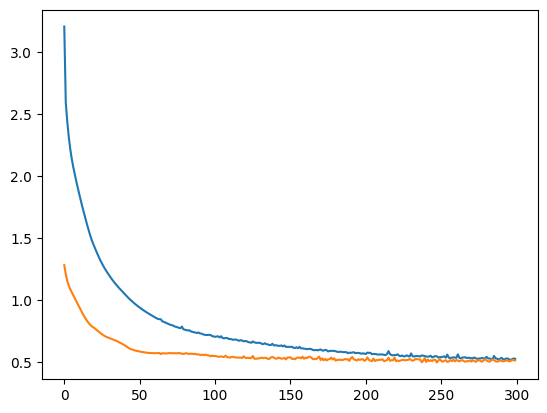

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [56]:
lstm_model.load_state_dict(torch.load("best_lstm_predictor.pth"))

<All keys matched successfully>

Erro de Teste: 0.0004456023743841797


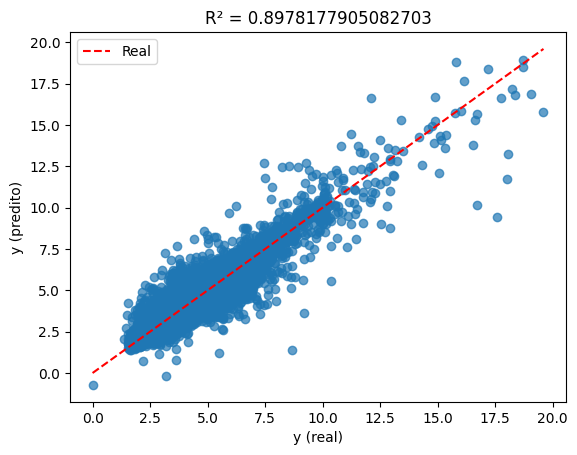

In [59]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

test_dataloader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn)

predictions_test = []
targets_test = []
loss_function = nn.MSELoss(reduction='mean')

with torch.no_grad():
    for batch_x, lengths, batch_y in test_dataloader:
        batch_x = batch_x.to(device)
        lengths = lengths.to(device)
        batch_y = batch_y.to(device)

        preds = lstm_model(batch_x, lengths)
        predictions_test.append(preds)
        targets_test.append(batch_y)

# concatena tudo e calcula o MSE
preds_all = torch.cat(predictions_test)
targets_all = torch.cat(targets_test)
erro_test = loss_function(preds_all, targets_all)
print(f"Erro de Teste: {erro_test.item()}")

# desfaz a normalização
y_true = scaler.inverse_transform(targets_all.cpu().numpy().reshape(-1, 1)).flatten()
y_pred  = scaler.inverse_transform(preds_all.cpu().numpy().reshape(-1, 1)).flatten()

r2 = r2_score(y_true=y_true, y_pred=y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Real')
plt.scatter(y_true, y_pred, alpha=0.7)
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.title(f"R² = {r2}")
plt.legend()
plt.show()